# Titanic Classification Problem

The competition details and datasets can be found in https://www.kaggle.com/competitions/titanic/overview.

Current score (accuracy): 0.75837

Ranked: 11139

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_df_original = pd.read_csv("../input/titanic/train.csv")
test_df_original = pd.read_csv("../input/titanic/test.csv")

In [3]:
train_df = train_df_original.copy()
test_df = test_df_original.copy()
# get example table of data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# check for missing info
train_df.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [5]:
# drop columns with lots of missing info and remove instances with missing info
train_df = train_df.drop('Cabin', axis=1)
test_df = test_df.drop('Cabin', axis=1)
train_df = train_df[train_df.Age.notnull()]
train_df = train_df[train_df.Embarked.notnull()]
# will remove age instances since 714 is still quite substantial compared to the original 891 entries

In [6]:
# sanity check instances
train_df.count()

PassengerId    712
Survived       712
Pclass         712
Name           712
Sex            712
Age            712
SibSp          712
Parch          712
Ticket         712
Fare           712
Embarked       712
dtype: int64

In [7]:
# should have 714 from ages, -2 more from embarked, correct amounts! 
# seems like instances with missing data did not have more than 1 feature missing
# delete features that do not contribute much to the model
# passengerId is unique to each passenger = useless
train_df = train_df.drop('PassengerId', axis=1)
# ticket is unique, and doesn't help since we have passenger class and fare as more useful info
train_df = train_df.drop('Ticket', axis=1)
test_df = test_df.drop('Ticket', axis=1)
# name is also pretty unique and we can't gleam much useful information from it. Family relations are defined in different columns
# seems to have people with different titles, e.g. Rev., Master, Col., etc, however seems more work than its worth
# investigate later!
train_df = train_df.drop('Name', axis=1)
test_df = test_df.drop('Name', axis=1)
# embarked does not seem useful since it doesn't matter who came from where, will come back to this if model needs some tweaking
train_df = train_df.drop('Embarked', axis=1)
test_df = test_df.drop('Embarked', axis=1)

In [8]:
# check new data
train_df.count()

Survived    712
Pclass      712
Sex         712
Age         712
SibSp       712
Parch       712
Fare        712
dtype: int64

          Survived    Pclass       Age     SibSp     Parch      Fare
Survived  1.000000 -0.356462 -0.082446 -0.015523  0.095265  0.266100
Pclass   -0.356462  1.000000 -0.365902  0.065187  0.023666 -0.552893
Age      -0.082446 -0.365902  1.000000 -0.307351 -0.187896  0.093143
SibSp    -0.015523  0.065187 -0.307351  1.000000  0.383338  0.139860
Parch     0.095265  0.023666 -0.187896  0.383338  1.000000  0.206624
Fare      0.266100 -0.552893  0.093143  0.139860  0.206624  1.000000


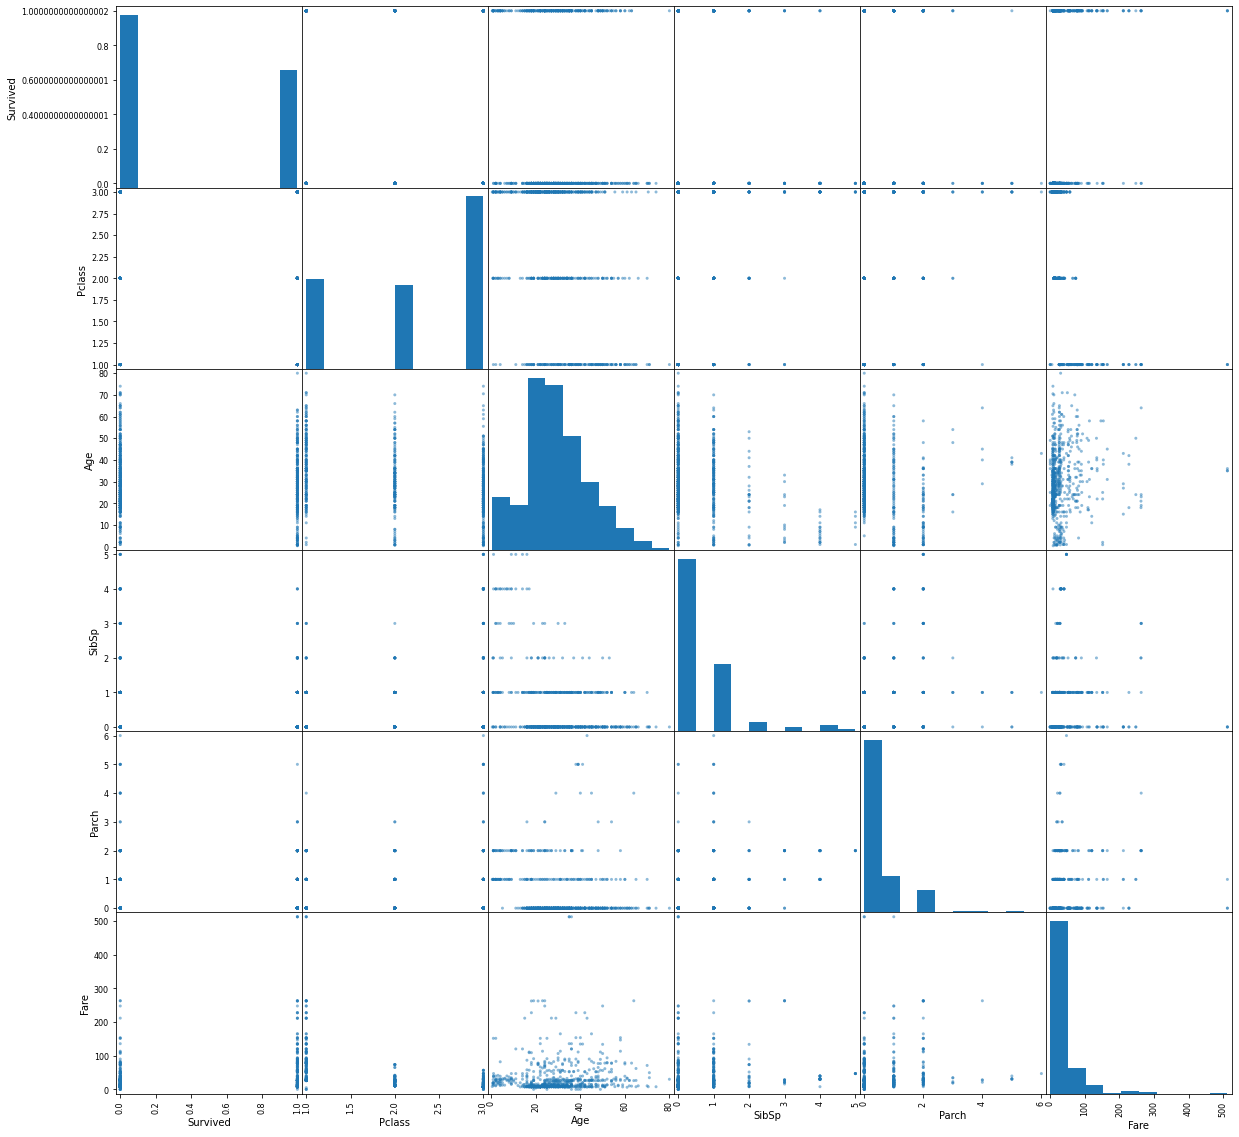

In [9]:
# columns look good
# see histograms and scatterplots of columns
pd.plotting.scatter_matrix(train_df, figsize=(20,20))
print(train_df.corr())

count    712.000000
mean      34.567251
std       52.938648
min        0.000000
25%        8.050000
50%       15.645850
75%       33.000000
max      512.329200
Name: Fare, dtype: float64

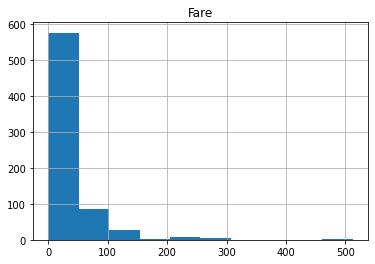

In [10]:
train_df.hist(column="Fare")
train_df["Fare"].describe()

In [11]:
# Maybe bucket this later, or reduce the scale 100x similar to parch and sibsp
print(len(train_df[train_df["Fare"] > 100.0]))
print(len(train_df[train_df["Fare"] > 150.0]))
print(len(train_df[train_df["Fare"] > 200.0]))

48
27
18


count    712.000000
mean       0.432584
std        0.854181
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        6.000000
Name: Parch, dtype: float64

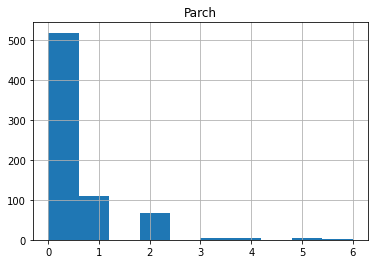

In [12]:
train_df.hist(column="Parch")
train_df["Parch"].describe()
# Also maybe bucket this later

count    712.000000
mean       0.514045
std        0.930692
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        5.000000
Name: SibSp, dtype: float64

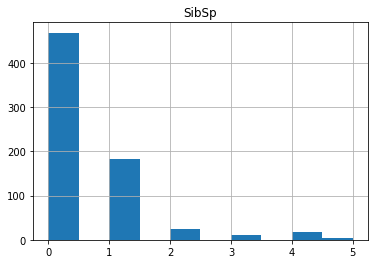

In [13]:
train_df.hist(column="SibSp")
train_df["SibSp"].describe()
# Also maybe bucket this later

count    712.000000
mean      29.642093
std       14.492933
min        0.420000
25%       20.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

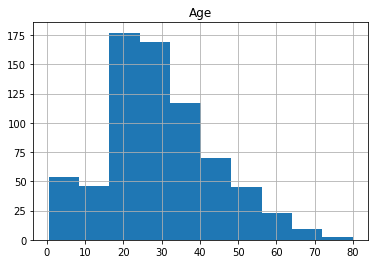

In [14]:
train_df.hist(column="Age")
train_df["Age"].describe()
# Probably should bucket this

count    712.000000
mean       2.240169
std        0.836854
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        3.000000
Name: Pclass, dtype: float64

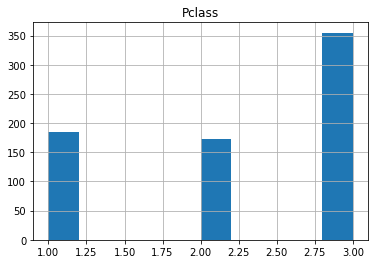

In [15]:
train_df.hist(column="Pclass")
train_df["Pclass"].describe()
# Already in "buckets", but maybe one-hot vector this

## Training model

In [16]:
# Drop survived column from training features
# Also shuffle data
train_df.drop("Survived", axis=1)
train_df.reindex(np.random.permutation(train_df.index))

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
231,0,3,male,29.0,0,0,7.7750
172,1,3,female,1.0,1,1,11.1333
817,0,2,male,31.0,1,1,37.0042
285,0,3,male,33.0,0,0,8.6625
515,0,1,male,47.0,0,0,34.0208
...,...,...,...,...,...,...,...
665,0,2,male,32.0,2,0,73.5000
731,0,3,male,11.0,0,0,18.7875
175,0,3,male,18.0,1,1,7.8542
616,0,3,male,34.0,1,1,14.4000


## Data prep

### Iteration 1, no data prep

In [17]:
# Iteration 1
# build a non-bucketized classification model first
# Columns:
# Pclass
# Sex
# Age
# SibSp
# Parch
# Fare
train_df_1 = train_df.copy()
test_df_1 = test_df.copy()

genders = {"male": 0, "female": 1}
data = [train_df_1, test_df_1]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

# convert floating data to ints and scale it reasonably
for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = (dataset['Fare'] / 100).astype(int)
    
for dataset in data:
    dataset['Age'] = dataset['Age'].fillna(0)
    dataset['Age'] = (dataset['Age'] / 100).astype(int)

In [18]:
X_train = train_df_1.drop("Survived", axis=1)
Y_train = train_df_1["Survived"]
X_test  = test_df_1.drop("PassengerId", axis=1).copy()

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred_logreg_1 = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)

# KNN
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)

Y_pred_knn_1 = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)

Y_pred_svc_1 = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [19]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Support Vector Machine', 'KNN'],
    'Score': [acc_log, acc_linear_svc, acc_knn]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head()

,Model
Score,
78.93,KNN
78.65,Logistic Regression
78.37,Support Vector Machine


## Iteration 2, bucket columns

In [20]:
# Iteration 2
# bucket columns by quadrants, around 5 max
# Columns:
# Pclass
# Sex
# Age
# SibSp
# Parch
# Fare
train_df_2 = train_df.copy()
test_df_2 = test_df.copy()

genders = {"male": 0, "female": 1}
data = [train_df_2, test_df_2]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

# convert floating data to ints and scale it reasonably
for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = pd.qcut(dataset['Fare'], q=5, labels=[0,1,2,3,4])
    
for dataset in data:
    dataset['Age'] = dataset['Age'].fillna(0)
    dataset['Age'] = pd.cut(dataset['Age'], bins=[-1, 0, 21, 27, 39, 100], labels=[0, 1, 2, 3, 4], retbins=False)
train_df_2.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,0,2,1,0,0
1,1,1,1,3,1,0,4
2,1,3,1,2,0,0,1
3,1,1,1,3,1,0,4
4,0,3,0,3,0,0,1


In [21]:
X_train = train_df_2.drop("Survived", axis=1)
Y_train = train_df_2["Survived"]
X_test  = test_df_2.drop("PassengerId", axis=1).copy()

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred_logreg_2 = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)

# KNN
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)

Y_pred_knn_2 = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)

Y_pred_svc_2 = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [22]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Support Vector Machine', 'KNN'],
    'Score': [acc_log, acc_linear_svc, acc_knn]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head()

,Model
Score,
85.53,KNN
80.20,Logistic Regression
78.93,Support Vector Machine


<!-- ## Iteration 3, one hot encode columns
Since dictionary mapping numeric value doesn't make too much sense with linear fitting, e.g. 3 is not 50% more likely to survive than 2 -->

In [23]:
# # Iteration 3
# # one hot encode
# # Columns:
# # Pclass
# # Sex
# # Age
# # SibSp
# # Parch
# # Fare
# train_df_3 = train_df.copy()
# test_df_3 = test_df.copy()

# data = [train_df_3, test_df_3]
# ohe = preprocessing.OneHotEncoder()

# def assign_ohe(dataset, arr, column):
#     for i in range(len(dataset[column])):
#         dataset[column][i] = arr[i]

# for dataset in data:
#     arr = ohe.fit_transform(dataset[['Sex']]).toarray()
#     assign_ohe(dataset, arr, 'Sex')

# for dataset in data:
#     dataset['Fare'] = dataset['Fare'].fillna(0)
#     dataset['Fare'] = pd.qcut(dataset['Fare'], q=5, labels=[0,1,2,3,4])
#     arr = ohe.fit_transform(dataset[['Fare']]).toarray()
#     print(arr)
#     assign_ohe(dataset, arr, 'Fare')
    
# for dataset in data:
#     dataset['Age'] = dataset['Age'].fillna(0)
#     dataset['Age'] = pd.cut(dataset['Age'], bins=[-1, 0, 21, 27, 39, 100], labels=[0, 1, 2, 3, 4], retbins=False)
#     arr = ohe.fit_transform(dataset[['Age']]).toarray()
# #     assign_ohe(dataset, arr, 'Age')
    
# train_df_3.head(20)

In [24]:
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_df_original['PassengerId'], Y_pred_knn_2]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='PassengerId,Survived',
    comments='',
)
!head submission.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,0
899,1
900,1
